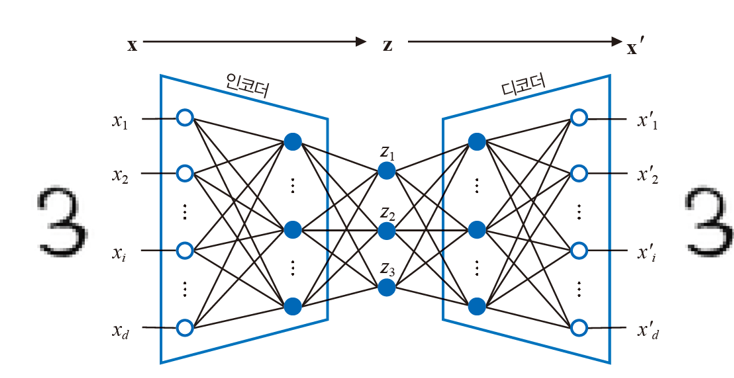

In [1]:
# 인코더는 차원을 줄이고 디코더는 차원을 회복  z공간을 장복공간

MNIST 를 이용해서 오토 인코더를 구현

In [2]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Flatten,Reshape,Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as k

In [3]:
(x_train,y_train),(x_test,y_test) =  mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
# (데이터개수,가로,세로,1)
x_train.shape

(60000, 28, 28)

In [5]:
x_train_reshape = np.expand_dims(x_train,axis=-1)
x_text_reshape = np.expand_dims(x_test,axis=-1)

In [6]:
# 잠복공간의 차원
zdim=32

In [7]:
x_text_reshape.shape[1:]

(28, 28, 1)

In [8]:
# Funtional API
# 중간에 층을 끼워넣기 편하다

In [9]:
encoder_input = Input(shape=x_text_reshape.shape[1:],name="input layer")
x = Conv2D(32,3,activation='relu',padding='same', name="conv2d_1")(encoder_input)
x = Conv2D(64,3,activation='relu',padding='same',name="conv2d_2")(x)
x = Conv2D(64,3,activation='relu',padding='same',name="conv2d_3")(x)
x=Flatten(name="flatten")(x)
encoder_output = Dense(zdim,name="dense")(x)
model_encoder = Model(encoder_input,encoder_output)
model_encoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 32)                1605664   
                                                                 
Total params: 1661408 (6.34 MB)
Trainable params: 1661408 (6.

In [10]:
np.prod(x_text_reshape.shape[1:]), x_text_reshape.shape[1:]

(784, (28, 28, 1))

In [11]:
decoder_input = Input(shape=(zdim,))

x = Dense(np.prod(x_text_reshape.shape[1:]))(decoder_input)
x=Reshape( x_text_reshape.shape[1:] )(x)
x=Conv2DTranspose(64,3,activation='relu',padding='same')(x)
x=Conv2DTranspose(64,3,activation='relu',padding='same')(x)
x=Conv2DTranspose(32,3,activation='relu',padding='same')(x)
x=Conv2DTranspose(1,3,activation='relu',padding='same')(x)
decoder_output = x
model_decoder = Model(decoder_input,decoder_output)
model_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 784)               25872     
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 28, 28, 64)        640       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 32)        1846

In [12]:
model_input = encoder_input
model_output = model_decoder(encoder_output)
model = Model(model_input,model_output)

In [13]:
model.compile(optimizer = 'adam', loss='mse')
model.fit(x_train_reshape,x_train_reshape,epochs=6,batch_size=128,shuffle=True,validation_data=(x_train_reshape,x_train_reshape))

Epoch 1/6
469/469 [==============================] - 25s 38ms/step - loss: 0.0142 - val_loss: 0.0059
Epoch 2/6
469/469 [==============================] - 16s 34ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 3/6
469/469 [==============================] - 17s 37ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 4/6
469/469 [==============================] - 17s 37ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 5/6
469/469 [==============================] - 17s 37ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 6/6
469/469 [==============================] - 16s 34ms/step - loss: 0.0037 - val_loss: 0.0037


In [14]:
model.save('autoencoder.keras')

In [15]:
import tensorflow as tf
# 저장된 모델 로드
loaded_model = tf.keras.models.load_model("autoencoder.keras")

In [16]:
# 복원 시험
decoded_img = model.predict(x_text_reshape)

313/313 [==============================] - 2s 4ms/step


In [17]:
decoded_img.shape

(10000, 28, 28, 1)

In [19]:
np.squeeze(decoded_img).shape

(10000, 28, 28)

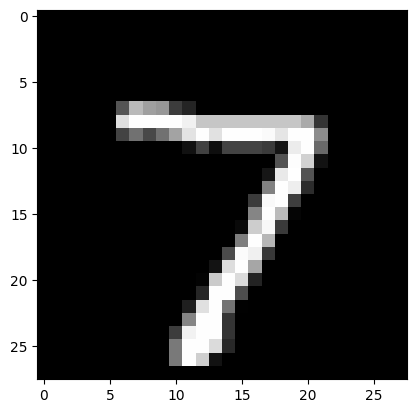

In [22]:
decoded_img_squeeze = np.squeeze(decoded_img)
import matplotlib.pyplot as plt
plt.imshow(x_test[0],cmap='gray')

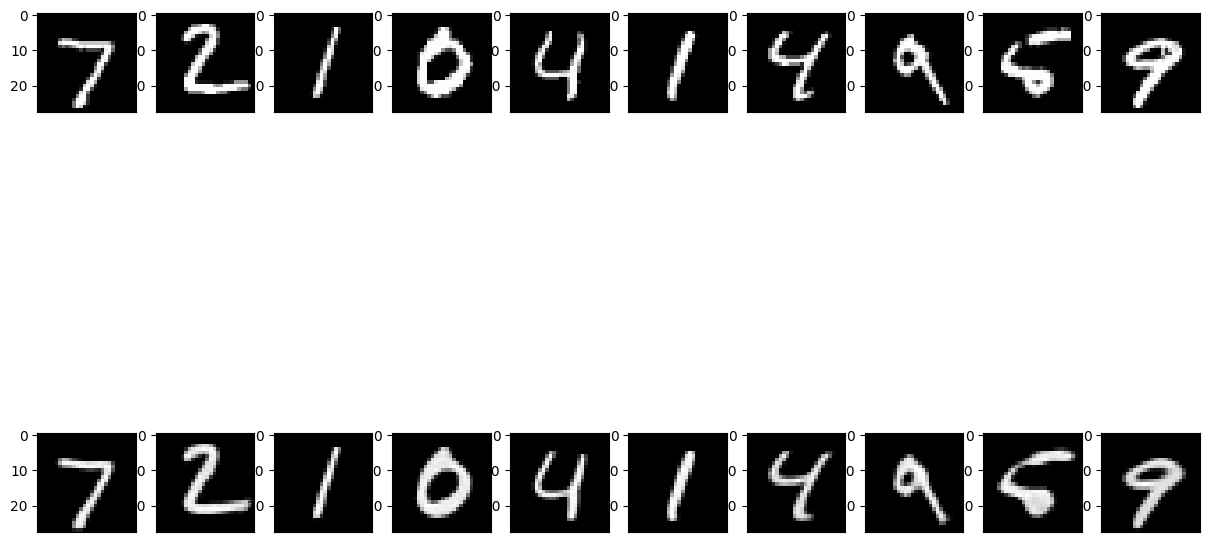

In [31]:
fig,ax = plt.subplots(2,10,figsize=(15,10))
for i in range(20):
  ax[i//10, i%10].imshow(x_test[i],cmap='gray')
  ax[i//10, i%10].set_xticks([])
  if i > 9:  # 복원한 이미지 10
    ax[i//10,i%10].imshow(decoded_img_squeeze[i-10],cmap='gray')
    ax[i//10,i%10].set_xticks([])
plt.show()